# Test ICXX prediction

Set up a toy example with a subsampled library of 500 variants, where not all mutations in the full library are seen. 

In [10]:
import pandas as pd
import polyclonal
import random
import numpy
from plotnine import *

In [11]:
noisy_data = (
    pd.read_csv('../notebooks/RBD_variants_escape_noisy.csv', na_filter=None)
    .query("library == 'avg3muts'")
    .query('concentration in [0.25, 1, 4]')
    .reset_index(drop=True)
    )

noisy_data

,library,aa_substitutions,concentration,prob_escape,IC90
0,avg3muts,,0.25,0.00000,0.1128
1,avg3muts,,0.25,0.01090,0.1128
2,avg3muts,,0.25,0.01458,0.1128
3,avg3muts,,0.25,0.09465,0.1128
4,avg3muts,,0.25,0.03299,0.1128
...,...,...,...,...,...
89995,avg3muts,Y449I L518Y C525R L461I,4.00,0.02197,2.3100
89996,avg3muts,Y449V K529R N394R,4.00,0.04925,0.9473
89997,avg3muts,Y451L N481T F490V,4.00,0.02315,0.9301
89998,avg3muts,Y453R V483G L492V N501P I332P,4.00,0.00000,5.0120


In [12]:
poly_abs = polyclonal.Polyclonal(data_to_fit=(noisy_data.groupby('concentration')
                                                        .apply(lambda x: x.sample(n=500, random_state=123))
                                                        .reset_index(drop = True)),
                                     activity_wt_df=pd.DataFrame.from_records(
                                         [('1', 1.0),
                                          ('2', 3.0),
                                          ('3', 2.0),
                                          ],
                                         columns=['epitope', 'activity'],
                                         ),
                                     site_escape_df=pd.DataFrame.from_records(
                                         [('1', 417, 10.0),
                                          ('2', 484, 10.0),
                                          ('3', 444, 10.0),
                                          ],
                                         columns=['epitope', 'site', 'escape'],
                                         ),
                                     data_mut_escape_overlap='fill_to_data',
                                 )
    
opt_res = poly_abs.fit(logfreq=500)

# First fitting site-level model.
# Starting optimization of 504 parameters at Wed Dec  1 22:20:57 2021.
       step   time_sec       loss   fit_loss reg_escape  regspread
          0  0.0082214     308.37     308.07    0.29701          0
        500     4.2136     21.298     16.412     4.8862          0
       1000     8.4836      20.62      15.47     5.1501          0
       1038     8.8174      20.62     15.472     5.1484          0
# Successfully finished at Wed Dec  1 22:21:06 2021.
# Starting optimization of 4659 parameters at Wed Dec  1 22:21:06 2021.
       step   time_sec       loss   fit_loss reg_escape  regspread
          0  0.0087821     67.751     15.733     52.018 8.2874e-30
        427     4.0899      19.25     5.4251     9.9417     3.8831
# Successfully finished at Wed Dec  1 22:21:10 2021.


In [16]:
num_unique_muts = len(poly_abs._muts_from_data_to_fit(poly_abs.data_to_fit)[2])
print(f"{num_unique_muts}/1932 mutations were seen during model fitting.")

1552/1932 mutations were seen during model fitting.


In [17]:
exact_data = (
    pd.read_csv('../notebooks/RBD_variants_escape_exact.csv', na_filter=None)
    .query('library == "avg3muts"')
    .query('concentration in [0.25, 0.5]')
    .reset_index(drop=True)
    )
exact_data

,library,aa_substitutions,concentration,prob_escape,IC90
0,avg3muts,,0.25,0.02512,0.1128
1,avg3muts,,0.25,0.02512,0.1128
2,avg3muts,,0.25,0.02512,0.1128
3,avg3muts,,0.25,0.02512,0.1128
4,avg3muts,,0.25,0.02512,0.1128
...,...,...,...,...,...
59995,avg3muts,Y508V,0.50,0.03305,0.2531
59996,avg3muts,Y508V H519D,0.25,0.39300,1.2960
59997,avg3muts,Y508V H519D,0.50,0.23920,1.2960
59998,avg3muts,Y508W,0.25,0.08727,0.2285


Correlation is 0.86


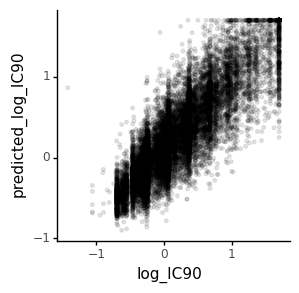

In [18]:
max_ic90 = 50

# we only need the variants, not the concentration for the IC90 comparison
ic90s = (exact_data[['aa_substitutions', 'IC90']]
         .assign(IC90=lambda x: x['IC90'].clip(upper=max_ic90))
         .drop_duplicates()
         )

ic90s = poly_abs.icXX(ic90s, x=0.9, col='predicted_IC90', max_c=max_ic90)

ic90s = (
    ic90s
    .assign(log_IC90=lambda x: numpy.log10(x['IC90']),
            predicted_log_IC90=lambda x: numpy.log10(x['predicted_IC90']),
            )
    )

corr = ic90s['log_IC90'].corr(ic90s['predicted_log_IC90'])
print(f"Correlation is {corr:.2f}")

ic90_corr_plot = (
    ggplot(ic90s) +
    aes('log_IC90', 'predicted_log_IC90') +
    geom_point(alpha=0.1, size=1) +
    theme_classic() +
    theme(figure_size=(3, 3))
    )

_ = ic90_corr_plot.draw()